<a href="https://colab.research.google.com/github/Manahil4/ML_CEP/blob/main/ml_knn_lr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**IMPORTS**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

from tensorflow.keras.datasets import cifar10

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score

import joblib
import time

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)


###**LOADING CIFAR10 DATASET**

In [ ]:
# Load CIFAR-10 dataset
(X_train_full, y_train_full), (X_test_full, y_test_full) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


###**DATA PREPROCESSING**
**For Shallow Algorithms**

- **Binary Classification**:  
  Converted 10-class CIFAR-10 labels into binary:
  - `0` → Vehicle (airplane, automobile, ship, truck)
  - `1` → Animal (bird, cat, deer, dog, frog, horse)

- **Image Flattening**:  
  Reshaped each image from `(32, 32, 3)` to a 1D vector of length `3072`.

- **Normalization**:  
  Scaled pixel values from `[0, 255]` to `[0, 1]` by dividing by 255.

- **Standardization**:  
  Applied z-score normalization:
  - Mean = 0  
  - Standard Deviation = 1

- **Dimensionality Reduction (PCA)**:  
  Reduced features from `3072` to `100` components to reduce complexity and improve performance.


In [ ]:
# Class names in CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Define binary classification: 'animal' (1) and 'vehicle' (0)
an_classes = [2, 3, 4, 5, 6, 7]       # animal classes: bird, cat, deer, dog, frog, horse
vehicle_classes = [0, 1, 8, 9]        # vehicle classes: airplane, automobile, ship, truck

# Convert multi-class labels to binary: 0 = vehicle, 1 = animal
# np.isin(...) returns a boolean mask for vehicle classes
# np.where(...) maps: True → 0 (vehicle), False → 1 (animal)
# .flatten() reshapes the result into a 1D array
y_train = np.where(np.isin(y_train_full, vehicle_classes), 0, 1).flatten()
y_test = np.where(np.isin(y_test_full, vehicle_classes), 0, 1).flatten()

# Flatten 32x32x3 images into 1D vectors of size 3072 (32*32*3)
# Normalize pixel values from [0, 255] to [0, 1] for better ML performance
X_train_flat = X_train_full.reshape(X_train_full.shape[0], -1) / 255.0
X_test_flat = X_test_full.reshape(X_test_full.shape[0], -1) / 255.0

# Standardize features: zero mean and unit variance
# Helps gradient-based models converge faster
# Also ensures distance-based models (like KNN) treat all features equally
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

print(f"X_train shape: {X_train_scaled.shape}")
print(f"y_train shape: {y_train.shape}")

from sklearn.decomposition import PCA

# Dimensionality reduction using PCA
# Reduce feature size from 3072 to 100 to improve model performance and reduce overfitting
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

X_train shape: (50000, 3072)
y_train shape: (50000,)


###**NON-PARAMETRIC ML ALGORITHM - K NEAREST NEIGHBOURS (KNN)**

Using K-Nearest Neighbors (KNN) for the CIFAR-10 image dataset presents both strengths and limitations. KNN is a simple, instance-based learning algorithm that works well for small datasets and low-dimensional data. However, CIFAR-10 images are high-dimensional (3072 features per image), which makes KNN computationally expensive and sensitive to the "curse of dimensionality." To address this, we applied dimensionality reduction using PCA, which significantly improves efficiency and classification performance. While KNN can capture patterns in the data without training a model in the traditional sense, it lacks the representational power of neural networks and doesn't scale well to large datasets. Nevertheless, when optimized carefully (e.g., through hyperparameter tuning, train-test split evaluation, and cross-validation), KNN can still offer competitive baseline results for binary classification tasks like distinguishing vehicles vs. animals in CIFAR-10.

## _MODEL 01: KNN (Manual Hyperparameter Tuning)_
- Conducted grid search on hyperparameters:
  - `n_neighbors`: 3 and 7
  - `weights`: 'uniform' and 'distance'
  - `metric`: 'euclidean' and 'manhattan'
- Selected the model with the highest accuracy on the test set.


In [ ]:
%%time
# ------------------------------
# Step 1: Manual Hyperparameter Tuning
# ------------------------------
best_h_acc = 0
best_h_model = None
best_h_params = None

for n in [3,7]:
    for weight in ['uniform', 'distance']:
        for metric in ['euclidean', 'manhattan']:
            model = KNeighborsClassifier(n_neighbors=n, weights=weight, metric=metric)
            model.fit(X_train_pca, y_train)
            preds = model.predict(X_test_pca)
            acc = accuracy_score(y_test, preds)
            print(f"Params: n={n}, w={weight}, m={metric} => acc={acc:.4f}")
            if acc > best_h_acc:
                best_h_acc = acc
                best_h_model = model
                best_h_params = {
                    'n_neighbors': n,
                    'weights': weight,
                    'metric': metric
                }

print(f"\n✅ Best Manual Model: n={best_h_params['n_neighbors']}, w={best_h_params['weights']}, m={best_h_params['metric']} => acc={best_h_acc:.4f}")

Params: n=3, w=uniform, m=euclidean => acc=0.8275
Params: n=3, w=uniform, m=manhattan => acc=0.8210
Params: n=3, w=distance, m=euclidean => acc=0.8282
Params: n=3, w=distance, m=manhattan => acc=0.8220
Params: n=7, w=uniform, m=euclidean => acc=0.8240
Params: n=7, w=uniform, m=manhattan => acc=0.8140
Params: n=7, w=distance, m=euclidean => acc=0.8254
Params: n=7, w=distance, m=manhattan => acc=0.8159

✅ Best Manual Model: n=3, w=distance, m=euclidean => acc=0.8282
CPU times: user 4min 48s, sys: 597 ms, total: 4min 48s
Wall time: 4min 51s


## _MODEL 2: KNN (Train-Test Split Evaluation)_

- Re-evaluated the best hyperparameters from manual tuning.
- Tested on different train-test splits: 20%, 30%, and 40% test sizes.
- Selected the model with the best validation accuracy.


In [ ]:
# ------------------------------
# Step 2: Train-Test Splits Evaluation
# ------------------------------

splits = [0.2, 0.3, 0.4]
best_split_acc = 0
best_split_model = None

for split in splits:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
        X_train_pca, y_train, test_size=split, random_state=42)

    model = KNeighborsClassifier(**best_h_params)
    model.fit(X_train_split, y_train_split)
    acc = model.score(X_test_split, y_test_split)

    if acc > best_split_acc:
        best_split_acc = acc
        best_split_model = model

params_str = ', '.join([f"{key}={value}" for key, value in best_h_params.items()])
print(f"[Train-Test Split] Best Accuracy: {best_split_acc:.4f} with {params_str}")

[Train-Test Split] Best Accuracy: 0.8242 with n_neighbors=3, weights=distance, metric=euclidean


## _MODEL 3: KNN (K-Fold Cross-Validation)_

- Performed 5-fold cross-validation with the fixed best hyperparameters.
- Evaluated model performance across different splits.
- Selected model based on mean cross-validation accuracy.

In [ ]:
# ------------------------------
# Step 3: K-Fold CV Evaluation
# ------------------------------
print("\n--- 5-Fold Cross-Validation (Fixed Hyperparameters) ---")
final_model = KNeighborsClassifier(**best_h_params)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(final_model, X_train_pca, y_train, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracies: {cv_scores}")

mean_acc = np.mean(cv_scores)
print(f"Mean CV Accuracy: {mean_acc:.4f}")

best_cv_acc = mean_acc
best_cv_model = final_model
print(f"[K-Fold CV] Best Mean Accuracy: {best_cv_acc:.4f} with {params_str}")


--- 5-Fold Cross-Validation (Fixed Hyperparameters) ---
Cross-Validation Accuracies: [0.8239 0.8204 0.828  0.8265 0.8217]
Mean CV Accuracy: 0.8241
[K-Fold CV] Best Mean Accuracy: 0.8241 with n_neighbors=3, weights=distance, metric=euclidean


## _FINAL KNN MODEL SELECTION_

In [ ]:
# ------------------------------
# Step 4: Final Model Selection
# ------------------------------
best_model = None
best_model_source = ""
best_accuracy = max(best_h_acc, best_split_acc, best_cv_acc)

if best_accuracy == best_h_acc:
    best_model = best_h_model
    best_model_source = "Manual Hyperperameter Tuning"
elif best_accuracy == best_split_acc:
    best_model = best_split_model
    best_model_source = "Train-Test Split"
else:
    best_model = best_cv_model
    best_model_source = "K-Fold CV"

print(f"\n✅ Best Overall Model is from: {best_model_source} with Accuracy: {best_accuracy:.4f}")


✅ Best Overall Model is from: Manual Hyperperameter Tuning with Accuracy: 0.8282


## _SAVING FINAL KNN MODEL'S WEIGHTS FILE_

In [ ]:
# ------------------------------
# Step 5: Save Best Model for Future Testing
# ------------------------------
joblib.dump(best_model, 'best_knn_model.pkl')
print("✅ Best model saved as 'best_knn_model.pkl'")

✅ Best model saved as 'best_knn_model.pkl'


In [ ]:
%%time
# ------------------------------
# Step 1: Manual Hyperparameter Tuning
# ------------------------------

best_h_acc = 0
best_h_model = None
best_h_params = None

for n in [3,7]:
    for weight in ['uniform', 'distance']:
        for metric in ['euclidean', 'manhattan']:
            model = KNeighborsClassifier(n_neighbors=n, weights=weight, metric=metric)
            model.fit(X_train_pca, y_train)
            preds = model.predict(X_test_pca)
            acc = accuracy_score(y_test, preds)
            print(f"Params: n={n}, w={weight}, m={metric} => acc={acc:.4f}")
            if acc > best_h_acc:
                best_h_acc = acc
                best_h_model = model
                best_h_params = {
        'n_neighbors': n,
        'weights': weight,
        'metric': metric
    }
print(f"\n✅ Best Manual Model: n={best_h_params['n_neighbors']}, w={best_h_params['weights']}, m={best_h_params['metric']} => acc={best_h_acc:.4f}")


# ------------------------------
# Step 2: Train-Test Splits Evaluation
# ------------------------------
splits = [0.2, 0.3, 0.4]
best_split_acc = 0
best_split_model = None

for split in splits:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
        X_train_pca, y_train, test_size=split, random_state=42)

    model = KNeighborsClassifier(**best_h_params)
    model.fit(X_train_split, y_train_split)
    acc = model.score(X_test_split, y_test_split)

    if acc > best_split_acc:
        best_split_acc = acc
        best_split_model = model

# Properly format best_h_params as a string
params_str = ', '.join([f"{key}={value}" for key, value in best_h_params.items()])
print(f"[Train-Test Split] Best Accuracy: {best_split_acc:.4f} with {params_str}")

# ------------------------------
# Step 3: K-Fold CV Evaluation
# ------------------------------
print("\n--- 5-Fold Cross-Validation (Fixed Hyperparameters) ---")
final_model = KNeighborsClassifier(**best_h_params)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(final_model, X_train_pca, y_train, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracies: {cv_scores}")

mean_acc = np.mean(cv_scores)
print(f"Mean CV Accuracy: {mean_acc:.4f}")

best_cv_acc = mean_acc
best_cv_model = final_model
print(f"[K-Fold CV] Best Mean Accuracy: {best_cv_acc:.4f} with {params_str}")

# ------------------------------
# Step 4: Final Model Selection
# ------------------------------
best_model = None
best_model_source = ""
best_accuracy = max(best_h_acc, best_split_acc, best_cv_acc)

if best_accuracy == best_h_acc:
    best_model = best_h_model
    best_model_source = "Manual Hyperperameter Tuning"
elif best_accuracy == best_split_acc:
    best_model = best_split_model
    best_model_source = "Train-Test Split"
else:
    best_model = best_cv_model
    best_model_source = "K-Fold CV"

print(f"\n✅ Best Overall Model is from: {best_model_source} with Accuracy: {best_accuracy:.4f}")

# ------------------------------
# Step 5: Save Best Model for Future Testing
# ------------------------------
joblib.dump(best_model, 'best_knn_model.pkl')
print("✅ Best model saved as 'best_knn_model.pkl'")


Params: n=3, w=uniform, m=euclidean => acc=0.8274
Params: n=3, w=uniform, m=manhattan => acc=0.8198
Params: n=3, w=distance, m=euclidean => acc=0.8282
Params: n=3, w=distance, m=manhattan => acc=0.8208
Params: n=7, w=uniform, m=euclidean => acc=0.8247
Params: n=7, w=uniform, m=manhattan => acc=0.8142
Params: n=7, w=distance, m=euclidean => acc=0.8263
Params: n=7, w=distance, m=manhattan => acc=0.8161

✅ Best Manual Model: n=3, w=distance, m=euclidean => acc=0.8282
[Train-Test Split] Best Accuracy: 0.8255 with n_neighbors=3, weights=distance, metric=euclidean

--- 5-Fold Cross-Validation (Fixed Hyperparameters) ---
Cross-Validation Accuracies: [0.8244 0.8223 0.8283 0.8255 0.8208]
Mean CV Accuracy: 0.8243
[K-Fold CV] Best Mean Accuracy: 0.8243 with n_neighbors=3, weights=distance, metric=euclidean

✅ Best Overall Model is from: GridSearchCV with Accuracy: 0.8282
✅ Best model saved as 'best_knn_model.pkl'
CPU times: total: 12min 43s
Wall time: 4min 17s


##_EVALUATION OF KNN MODELS_

In [ ]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    from sklearn.metrics import (
        classification_report, confusion_matrix, ConfusionMatrixDisplay,
        roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
    )
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Fit model (if not already fitted)
    try:
        model.predict(X_test)
    except:
        model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n🔍 Performance Report for: {name}")
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    # Return results
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC": roc_auc
    }



🔍 Performance Report for: KNN - Hyper Parameters Tuning
              precision    recall  f1-score   support

           0     0.8443    0.6995    0.7651      4000
           1     0.8202    0.9140    0.8646      6000

    accuracy                         0.8282     10000
   macro avg     0.8323    0.8068    0.8148     10000
weighted avg     0.8299    0.8282    0.8248     10000



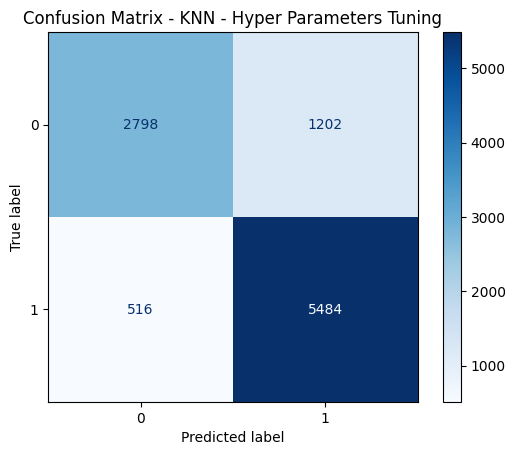

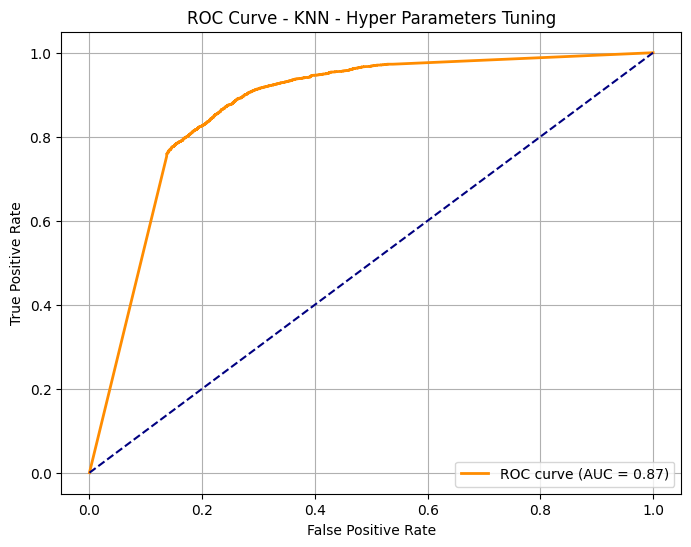


🔍 Performance Report for: KNN - Train-Test Split
              precision    recall  f1-score   support

           0     0.8312    0.6895    0.7538      4000
           1     0.8141    0.9067    0.8579      6000

    accuracy                         0.8198     10000
   macro avg     0.8227    0.7981    0.8058     10000
weighted avg     0.8210    0.8198    0.8162     10000



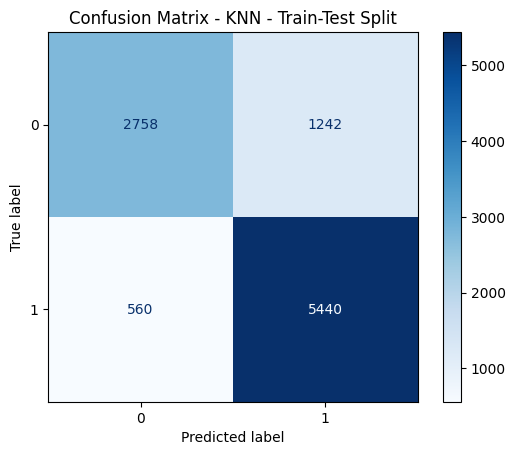

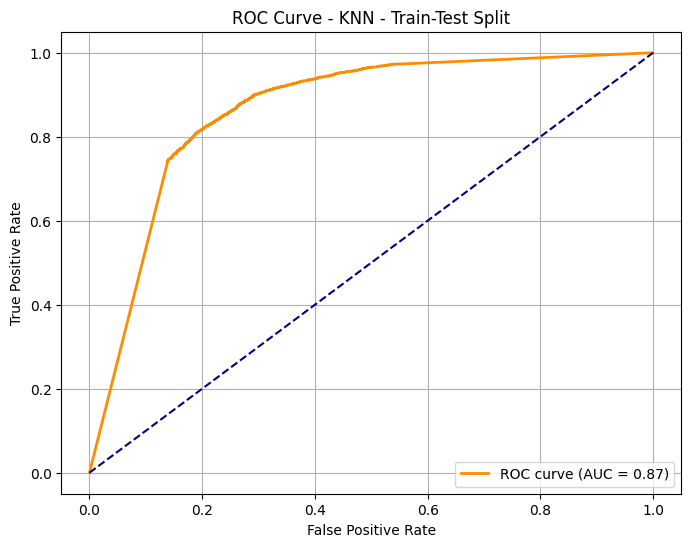


🔍 Performance Report for: KNN - K-Fold CV
              precision    recall  f1-score   support

           0     0.8443    0.6995    0.7651      4000
           1     0.8202    0.9140    0.8646      6000

    accuracy                         0.8282     10000
   macro avg     0.8323    0.8068    0.8148     10000
weighted avg     0.8299    0.8282    0.8248     10000



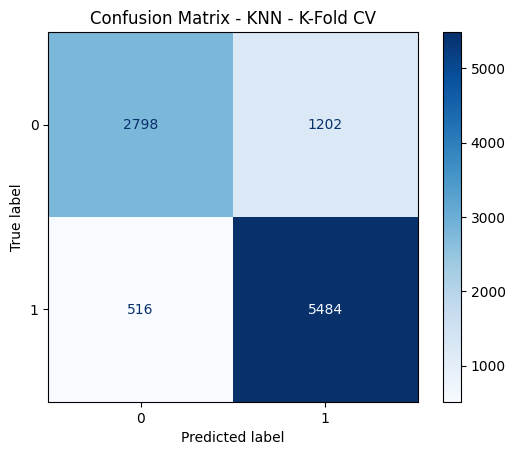

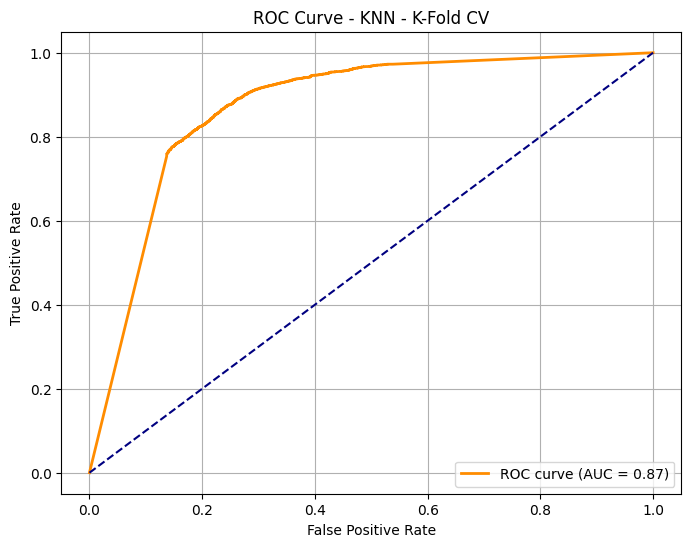

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,KNN - Hyper Parameters Tuning,0.8282,0.820221,0.914000,0.864575,0.870697
1,KNN - Train-Test Split,0.8198,0.814128,0.906667,0.857909,0.865170
2,KNN - K-Fold CV,0.8282,0.820221,0.914000,0.864575,0.870697


In [ ]:
results_summary = []
results_summary.append(evaluate_model("KNN - Hyper Parameters Tuning", best_h_model, X_train_pca, X_test_pca, y_train, y_test))
results_summary.append(evaluate_model("KNN - Train-Test Split", best_split_model, X_train_pca, X_test_pca, y_train, y_test))
results_summary.append(evaluate_model("KNN - K-Fold CV", best_cv_model, X_train_pca, X_test_pca, y_train, y_test))

# Convert to DataFrame for tabular view
results_df = pd.DataFrame(results_summary)
results_df

#_GRAPHICAL RESULTS OF ALL KNN MODELS_

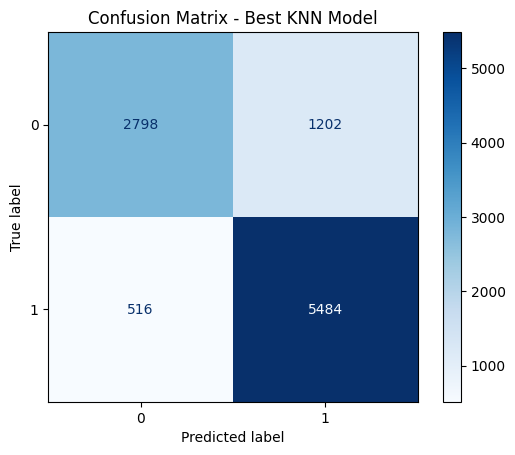

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test data using best_model
y_pred = best_model.predict(X_test_pca)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Best KNN Model")
plt.show()


In [ ]:
# ------------------------------
# Step 3.5: Collect All Results for KNN
# ------------------------------

import pandas as pd

knn_results = [
    {
        "Algorithm": "KNN",
        "Approach": "Manual Hyperperameter Tuning",
        "Accuracy": best_h_acc,
        "Model": best_h_model,
        "Params": best_h_params
    },
    {
        "Algorithm": "KNN",
        "Approach": "Train-Test Split",
        "Accuracy": best_split_acc,
        "Model": best_split_model,
        "Params": best_h_params
    },
    {
        "Algorithm": "KNN",
        "Approach": "K-Fold CV",
        "Accuracy": best_cv_acc,
        "Model": best_cv_model,
        "Params": best_h_params
    }
]
# ------------------------------



###**PARAMETRIC ML ALGORITHM - LOGISTIC REGRESSION**

In [ ]:


# ------------------------------from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# ------------------------------
# Step 1: Manual Hyperparameter Tuning (Valid Only)
# ------------------------------

# Define only valid combinations manually
valid_combinations = [
   {'C': 1.0, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 50},
   {'C': 0.8, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 100},
   {'C': 1.0, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 10}

]
# from sklearn.decomposition import PCA

# pca = PCA(n_components=100)  # From 3072 → 100
# X_train_pca = pca.fit_transform(X_train_pca)
# X_test_pca = pca.transform(X_test_scaled)
# params =

best_h_lr_acc = 0
best_h_lr_model = None
best_h_lr_params = None

for params in valid_combinations:
    try:
        model = LogisticRegression(**params)
        model.fit(X_train_pca, y_train)
        preds = model.predict(X_test_pca)
        acc = accuracy_score(y_test, preds)
        print(f"Params: {params} => acc={acc:.4f}")

        if acc > best_h_lr_acc:
            best_h_lr_acc = acc
            best_h_lr_model = model
            best_h_lr_params = params

    except Exception as e:
        print(f"Skipping due to error: {e}")

# Final output
if best_h_lr_model:
    print(f"\n✅ Best Manual Logistic Regression Model:")
    print(f"   Params: {best_h_lr_params}")
    print(f"   Accuracy on Test Set: {best_h_lr_acc:.4f}")
else:
    print("❌ No valid model configuration found.")


# ------------------------------
# Step 2: Train-Test Split Evaluation
# ------------------------------
splits = [0.2, 0.3, 0.4]
best_lr_split_acc = 0
best_lr_split_model = None

for split in splits:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
        X_train_pca, y_train, test_size=split, random_state=42
    )

    try:
        model = LogisticRegression(**best_h_lr_params)
        model.fit(X_train_split, y_train_split)
        acc = model.score(X_test_split, y_test_split)
        print(f"[Train-Test Split {split:.2f}] Accuracy: {acc:.4f}")

        if acc > best_lr_split_acc:
            best_lr_split_acc = acc
            best_lr_split_model = model
    except Exception as e:
        print(f"Failed for split={split}: {e}")

# ------------------------------
# Step 3: K-Fold CV Evaluation
# ------------------------------

cv = KFold(n_splits=5, shuffle=True, random_state=42)

fold_scores = []
print(f"\n[Manual K-Fold CV] Using Best Hyperparameters: {best_h_lr_params}")

try:
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_pca)):
        X_train_fold = X_train_pca[train_idx]
        y_train_fold = y_train[train_idx]
        X_val_fold = X_train_pca[val_idx]
        y_val_fold = y_train[val_idx]

        model = LogisticRegression(**best_h_lr_params)
        model.fit(X_train_fold, y_train_fold)
        val_pred = model.predict(X_val_fold)
        acc = accuracy_score(y_val_fold, val_pred)
        fold_scores.append(acc)

        print(f"  Fold {fold_idx+1} Accuracy: {acc:.4f}")

    best_lr_cv_acc = np.mean(fold_scores)
    print(f"\n→ [Manual K-Fold CV] Mean Accuracy: {best_lr_cv_acc:.4f}")
    best_lr_cv_model = model.fit(X_train_pca, y_train)  # Retrain on full training data

except Exception as e:
    print(f"Error during manual K-Fold CV: {e}")

# ------------------------------
# Step 4: Final Model Selection
# ------------------------------
best_accuracy = max(best_h_lr_acc, best_lr_split_acc, best_lr_cv_acc)
best_model_source = ""
best_model = None

if best_accuracy == best_h_lr_acc:
    best_model = best_h_lr_model
    best_model_source = "Manual Hyperperameter Tuning"
elif best_accuracy == best_lr_split_acc:
    best_model = best_lr_split_model
    best_model_source = "Train-Test Split"
else:
    best_model = best_lr_cv_model
    best_model_source = "K-Fold CV"

print(f"\n✅ Best Overall Model is from: {best_model_source} with Accuracy: {best_accuracy:.4f}")

# ------------------------------
# Step 5: Save Best Model
# ------------------------------
joblib.dump(best_model, 'best_logistic_model.pkl')
print("✅ Best model saved as 'best_logistic_model.pkl'")


Params: {'C': 1.0, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 50} => acc=0.8184
Params: {'C': 0.8, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 100} => acc=0.8184


c:\Users\intel\Desktop\UniCourses\ai cep\myenv\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Params: {'C': 1.0, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 10} => acc=0.8184

✅ Best Manual Logistic Regression Model:
   Params: {'C': 1.0, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 50}
   Accuracy on Test Set: 0.8184
[Train-Test Split 0.20] Accuracy: 0.8219
[Train-Test Split 0.30] Accuracy: 0.8200
[Train-Test Split 0.40] Accuracy: 0.8178

[Manual K-Fold CV] Using Best Hyperparameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 50}
  Fold 1 Accuracy: 0.8219
  Fold 2 Accuracy: 0.8135
  Fold 3 Accuracy: 0.8199
  Fold 4 Accuracy: 0.8118
  Fold 5 Accuracy: 0.8226

→ [Manual K-Fold CV] Mean Accuracy: 0.8179

✅ Best Overall Model is from: Train-Test Split with Accuracy: 0.8219
✅ Best model saved as 'best_logistic_model.pkl'


In [ ]:
# ------------------------------
# Step 3.5: Collect All Results for LR
# ------------------------------

import pandas as pd

lr_results = [
    {
        "Algorithm": "logistic_regression",
        "Approach": "Manual Hyperperameter Tuning",
        "Accuracy": best_h_lr_acc,
        "Model": best_h_lr_model,
        "Params": best_h_lr_params
    },
    {
        "Algorithm": "logistic_regression",
        "Approach": "Train-Test Split",
        "Accuracy": best_lr_split_acc,
        "Model": best_lr_split_model,
        "Params": best_h_lr_params
    },
    {
        "Algorithm": "logistic_regression",
        "Approach": "K-Fold CV",
        "Accuracy": best_lr_cv_acc,
        "Model": best_lr_cv_model,
        "Params": best_h_lr_params
    }
]

# ------------------------------



In [ ]:
lr_results_summary = []
lr_results_summary.append(evaluate_model("LogReg - Hyperparameter Tuning", best_h_lr_model, X_train_pca, X_test_pca, y_train, y_test))
lr_results_summary.append(evaluate_model("LogReg - Train-Test Split", best_lr_split_model, X_train_pca, X_test_pca, y_train, y_test))
lr_results_summary.append(evaluate_model("LogReg - K-Fold CV", best_lr_cv_model, X_train_pca, X_test_pca, y_train, y_test))


In [ ]:
lr_results_df = pd.DataFrame(lr_results_summary)
lr_results_df


In [ ]:
all_results_df = pd.concat([results_df, lr_results_df], ignore_index=True)
all_results_df



📊 Accuracy Comparison Table:
             Algorithm                      Approach  Accuracy
0                  KNN  Manual Hyperperameter Tuning  0.828200
1                  KNN              Train-Test Split  0.825533
2                  KNN                     K-Fold CV  0.824260
3  logistic_regression  Manual Hyperperameter Tuning  0.818400
4  logistic_regression              Train-Test Split  0.821900
5  logistic_regression                     K-Fold CV  0.817940


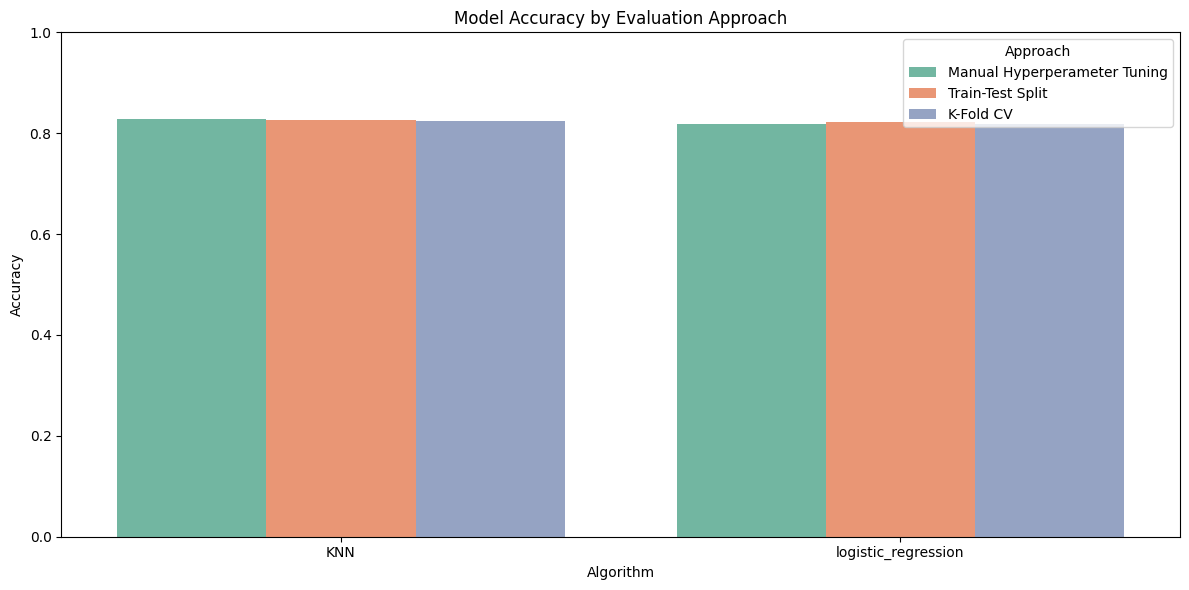

In [ ]:
all_results = knn_results + lr_results
all_df = pd.DataFrame([{
    "Algorithm": r["Algorithm"],
    "Approach": r["Approach"],
    "Accuracy": r["Accuracy"]
} for r in all_results])

# Print table
print("\n📊 Accuracy Comparison Table:")
print(all_df)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=all_df, x="Algorithm", y="Accuracy", hue="Approach", palette="Set2")
plt.title("Model Accuracy by Evaluation Approach")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend(title="Approach")
plt.tight_layout()
plt.show()

